# Imports

In [ ]:
from google.colab import drive
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from collections import Counter
from torch.utils.data import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the line below to show inline in a notebook
%matplotlib inline

drive.mount('/content/drive/')
%cd 'drive/MyDrive/Colab Notebooks/NLP2'

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/NLP2


In [ ]:
# pip install wordcloud
from wordcloud import WordCloud

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# from google.colab import files
# files.upload()

import preprocessing

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


# Utils

In [14]:
CSV_PATH = "dataset.csv"
pd.set_option("display.max_columns", None)
dataset_csv = pd.read_csv(CSV_PATH,  index_col=0)
print(dataset_csv.head())

  artist    year                         song        album  \
0   ABBA  1973.0  Another Town, Another Train  "Ring Ring"   
1   ABBA  1973.0                  Disillusion  "Ring Ring"   
2   ABBA  1973.0             People Need Love  "Ring Ring"   
3   ABBA  1973.0       I Saw It In The Mirror  "Ring Ring"   
4   ABBA  1973.0       Nina, Pretty Ballerina  "Ring Ring"   

                                              lyrics  
0  \n\nDay is dawning and I must go\nYou're aslee...  
1  \n\nChanging, moving, in a circle\nI can see y...  
2  \n\nPeople need hope, people need loving\nPeop...  
3  \n\nI saw it in the mirror, I saw it in my fac...  
4  \n\nEvery day in the morning on her way to the...  


In [ ]:
def horizontal_plot(x, y, title, xlabel, ylabel, fig_size):
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ax.barh(x, y, align='center', linewidth=5)
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.title(title)
    plt.xlabel(ylabel)
    plt.ylabel(xlabel)
    plt.show()    

def vertical_plot(x, y, title, xlabel, ylabel, fig_size):
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ax.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()       

In [ ]:
class LyricsDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.lyrics_csv = pd.read_csv(csv_file, index_col=0)
        self.transform = transform

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, idx):
        song_info = dict(zip(self.lyrics_csv.columns, self.lyrics_csv.iloc[idx]))
        if self.transform:
            song_info = self.transform(song_info)
        return song_info


def parse_csv_data(song_info):
    song_info["year"] = int(song_info["year"])
    print("before clean-up", {"lyrics": song_info["lyrics"]} )
    song_info["lyrics"] = " ".join( preprocessing.normalization(song_info["lyrics"]) )
    return song_info


# dataset = LyricsDataset(CSV_PATH, transform=parse_csv_data)

# print("example: ", dataset[0])

In [ ]:
def plot_similarity_matrix(similarity, labels, size, artist_name, fig_size=10):
    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    cmap = cm.get_cmap('YlGnBu_r')

    similarity = [[1-elem for elem in line] for line in similarity]
    cax = ax.matshow(similarity, interpolation='nearest', cmap=cmap)

    ax.grid(True)
    plt.title("Songs Similarity Matrix for {0}".format(artist_name))
    plt.xticks(range(size), labels)
    plt.yticks(range(size), labels)
    fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    plt.show()


def split_long_text(text):
    split_text = []
    while len(text) > 10:
        line = text[:10] + text[10:].split(" ")[0] + "\n"
        text = " ".join(text[10:].split(" ")[1:])
        split_text.append(line)
    if text != "":
        split_text.append(text)
    else:
        split_text[-1] = split_text[-1][:-1]
    return "".join(split_text)

def clean_lyrics(lyrics):
    return " ".join( preprocessing.normalization(lyrics))

def get_selected_songs(dataset_csv, selected_artist, selected_songs_idx):
    artist_songs = dataset_csv.loc[dataset_csv['artist'] == selected_artist]
    
    if selected_songs_idx is not None:
        selected_songs_lyrics = []
        selected_songs_names = []
        for idx in selected_songs_idx:
            selected_songs_lyrics.append(artist_songs["lyrics"].iloc[idx])
            selected_songs_names.append(split_long_text(artist_songs["song"].iloc[idx]))
        song_lyrics = selected_songs_lyrics
        labels = selected_songs_names
        return song_lyrics, labels
    else:
        return artist_songs["lyrics"], range(len(artist_songs["lyrics"]))
        

def compute_pairwise_similarities_for_artist(dataset_csv, selected_artist, selected_songs=None, fig_size=10):
    song_lyrics, labels = get_selected_songs(dataset_csv, selected_artist, selected_songs)
    
    size = len(song_lyrics)
    tfidf = TfidfVectorizer().fit_transform(song_lyrics)
    # no need to normalize, since Vectorizer will return normalized tf-idf
    pairwise_similarity = tfidf * tfidf.T
    plot_similarity_matrix(pairwise_similarity.toarray(), labels, size, selected_artist, fig_size)


def compute_pairwise_similarities_for_diff_artist(dataset_csv, artist_1, songs_1, artist_2, songs_2, fig_size=10):
    song_lyrics_1, labels_1 = get_selected_songs(dataset_csv, artist_1, songs_1)
    song_lyrics_2, labels_2 = get_selected_songs(dataset_csv, artist_2, songs_2)
    
    labels_1 = [artist_1 + "\n" + label for label in labels_1]
    labels_2 = [artist_2 + "\n" + label for label in labels_2]

    song_lyrics_1.extend(song_lyrics_2)
    labels_1.extend(labels_2)

    size = len(song_lyrics_1)
    tfidf = TfidfVectorizer().fit_transform(song_lyrics_1)
    # no need to normalize, since Vectorizer will return normalized tf-idf
    pairwise_similarity = tfidf * tfidf.T
    plot_similarity_matrix(pairwise_similarity.toarray(), labels_1, size, artist_1, fig_size)



In [ ]:
def get_artist_names(dataset_csv):
    return list(Counter(dataset_csv['artist']).keys())
    
def get_songs_per_artist(dataset_csv):
    return list(Counter(dataset_csv['artist']).values())

def get_songs_per_artist(dataset_csv):
    return list(Counter(dataset_csv['artist']).values())
    

def get_albums_per_artist(dataset_csv):
    artist_names = get_artist_names(dataset_csv)
    albums_freq = []
    for artist in artist_names:
        artist_info = dataset_csv.loc[dataset_csv['artist'] == artist]
        artist_albums = list(Counter(artist_info['album']).keys())
        if artist_albums != [] and artist_albums[-1] != artist_albums[-1]:
            artist_albums = artist_albums[:-1]
        albums_freq.append(len(artist_albums))
    return albums_freq


def get_years(dataset_csv):
    years = list(Counter(dataset_csv['year']).keys())
    # ignore songs without album
    years = [int(year) for year in years if year == year]
    years.sort()
    return years

def get_albums_per_year(dataset_csv):
    years = get_years(dataset_csv)
    
    albums_freq = []
    for year in years:
        year_albums = dataset_csv.loc[dataset_csv['year'] == year]
        year_albums = list(Counter(year_albums['album']).keys())
        albums_freq.append(len(year_albums))
    return albums_freq


In [67]:
def get_word_cloud_for_artist(selected_artist):
    lyrics = dataset_csv.loc[dataset_csv['artist'] == selected_artist]["lyrics"]
    lyrics = [clean_lyrics(song) for song in lyrics]

    tfidf = TfidfVectorizer(max_df=0.90, min_df=0.2)
    tfidf.fit_transform(lyrics)
    text = " ".join(tfidf.get_feature_names_out())
    
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Dataset Plots
- Per-artist songs distribution
- Per-artist albums distribution
- Per-year albums distribution

In [ ]:
len(get_artist_names(dataset_csv))

38

[('ABBA', 112), ('AC/DC', 197), ('Adele', 71), ('Akon', 158), ('Alan Walker', 49), ('Alec Benjamin', 81), ('All Time Low', 149), ('Ariana Grande', 161), ('Avicii', 67), ('Avril Lavigne', 127), ('AWOLNATION', 69), ('Backstreet Boys', 201), ('Bastille', 131), ('The Beatles', 420), ('Barbra Streisand', 525), ('Bob Dylan', 508), ('Celine Dion', 216), ('Depeche Mode', 191), ('Ed Sheeran', 208), ('Elvis Presley', 785), ('Eminem', 398), ("Guns N' Roses", 110), ('Justin Timberlake', 93), ('Labrinth', 50), ('Lorde', 56), ('Madonna', 306), ('Maroon 5', 132), ('Metallica', 162), ('Michael Jackson', 247), ('Muse', 163), ('Nicki Minaj', 247), ('Panic! At The Disco', 119), ('Paul McCartney', 384), ('Post Malone', 87), ('Queen', 188), ('Sam Smith', 84), ('Selena Gomez', 93), ('Usher', 200)]


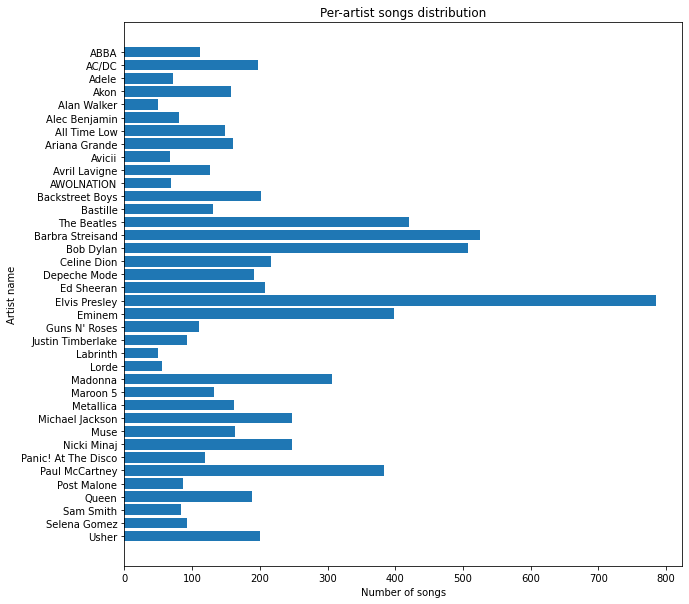

In [ ]:
print(list(zip(get_artist_names(dataset_csv), get_artist_freq(dataset_csv))))
horizontal_plot(get_artist_names(dataset_csv), get_artist_freq(dataset_csv), 'Per-artist songs distribution', 'Artist name', 'Number of songs', 10)

[('ABBA', 9), ('AC/DC', 18), ('Adele', 4), ('Akon', 7), ('Alan Walker', 4), ('Alec Benjamin', 5), ('All Time Low', 10), ('Ariana Grande', 8), ('Avicii', 4), ('Avril Lavigne', 6), ('AWOLNATION', 6), ('Backstreet Boys', 10), ('Bastille', 10), ('The Beatles', 20), ('Barbra Streisand', 49), ('Bob Dylan', 39), ('Celine Dion', 15), ('Depeche Mode', 14), ('Ed Sheeran', 13), ('Elvis Presley', 62), ('Eminem', 19), ("Guns N' Roses", 6), ('Justin Timberlake', 5), ('Labrinth', 4), ('Lorde', 4), ('Madonna', 20), ('Maroon 5', 7), ('Metallica', 14), ('Michael Jackson', 17), ('Muse', 10), ('Nicki Minaj', 9), ('Panic! At The Disco', 6), ('Paul McCartney', 25), ('Post Malone', 4), ('Queen', 15), ('Sam Smith', 5), ('Selena Gomez', 4), ('Usher', 10)]


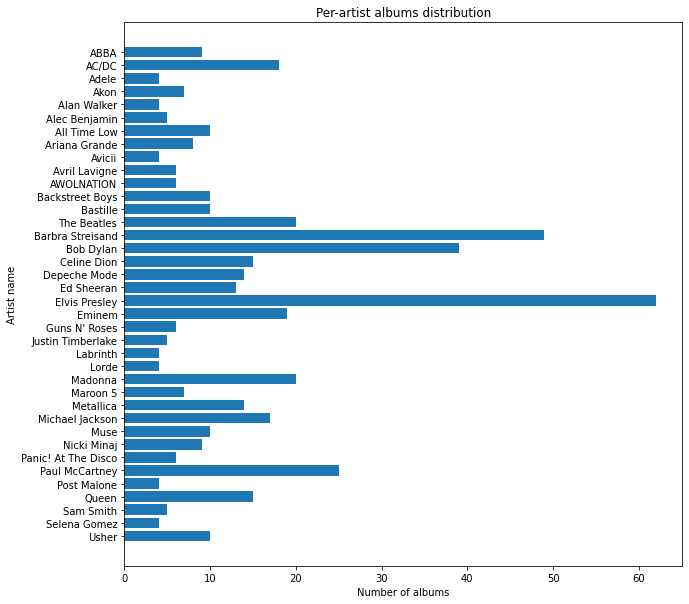

In [ ]:
print(list(zip(get_artist_names(dataset_csv), get_albums_per_artist(dataset_csv))))
horizontal_plot(get_artist_names(dataset_csv), get_albums_per_artist(dataset_csv), 'Per-artist albums distribution', 'Artist name', 'Number of albums', 10)

[(1956, 2), (1957, 3), (1958, 2), (1959, 3), (1960, 3), (1961, 2), (1962, 4), (1963, 8), (1964, 9), (1965, 9), (1966, 7), (1967, 8), (1968, 5), (1969, 9), (1970, 9), (1971, 9), (1972, 5), (1973, 9), (1974, 8), (1975, 10), (1976, 7), (1977, 5), (1978, 4), (1979, 6), (1980, 6), (1981, 5), (1982, 4), (1983, 7), (1984, 8), (1985, 3), (1986, 7), (1987, 5), (1988, 8), (1989, 4), (1990, 6), (1991, 7), (1992, 3), (1993, 6), (1994, 4), (1995, 6), (1996, 6), (1997, 11), (1998, 4), (1999, 7), (2000, 4), (2001, 7), (2002, 8), (2003, 9), (2004, 7), (2005, 9), (2006, 8), (2007, 8), (2008, 11), (2009, 11), (2010, 10), (2011, 15), (2012, 17), (2013, 22), (2014, 11), (2015, 10), (2016, 10), (2017, 9), (2018, 14), (2019, 12), (2020, 12), (2021, 9), (2022, 1)]


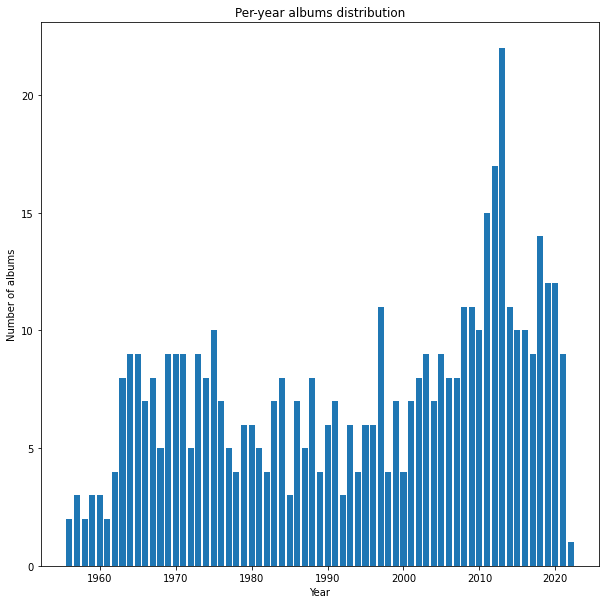

In [ ]:
print(list(zip(get_years(dataset_csv), get_albums_per_year(dataset_csv))))
vertical_plot(get_years(dataset_csv), get_albums_per_year(dataset_csv), 'Per-year albums distribution', 'Year', 'Number of albums', 10)

# Similarity Plots

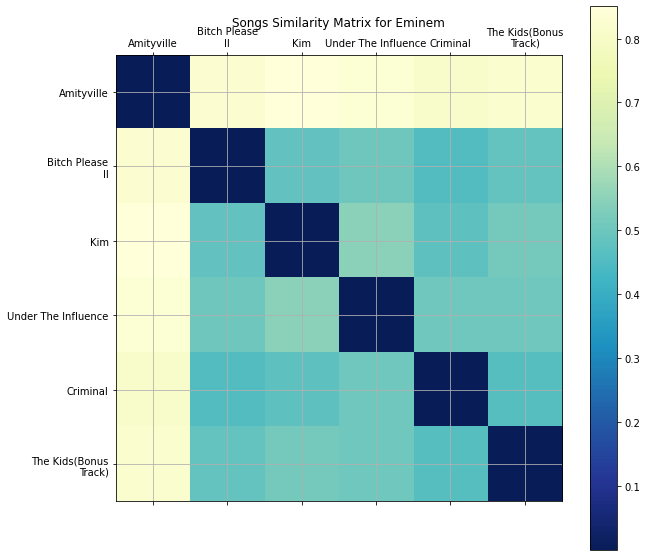

In [ ]:
selected_artist = "Eminem"
selected_songs = [54, 55, 56, 57, 58, 59]

compute_pairwise_similarities_for_artist(dataset_csv, selected_artist, selected_songs)

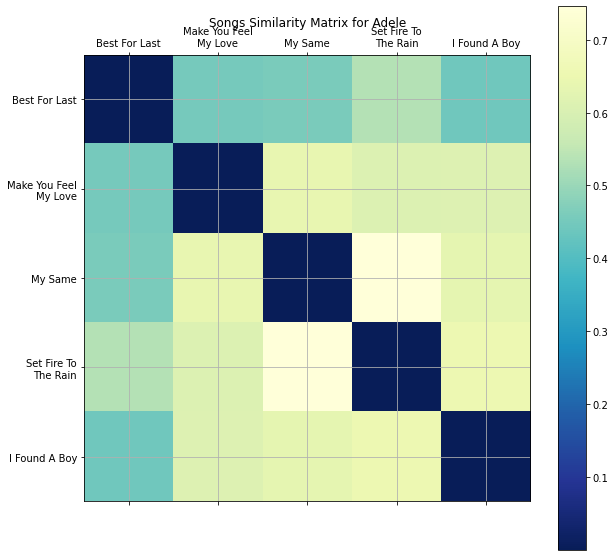

In [ ]:
selected_artist = "Adele"
selected_songs = [1, 8, 9, 20, 27]

# compute_pairwise_similarities_for_artist(dataset_csv, selected_artist)
compute_pairwise_similarities_for_artist(dataset_csv, selected_artist, selected_songs)

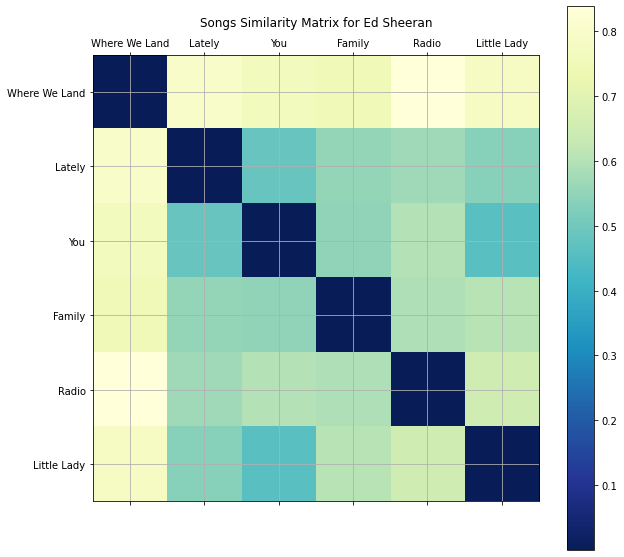

In [ ]:
# compute_pairwise_similarities_for_artist(dataset_csv, "Celine Dion", [93,94,95,96,97,98,99,100,101])
compute_pairwise_similarities_for_artist(dataset_csv, "Ed Sheeran", [46, 47, 48, 49, 50, 51])

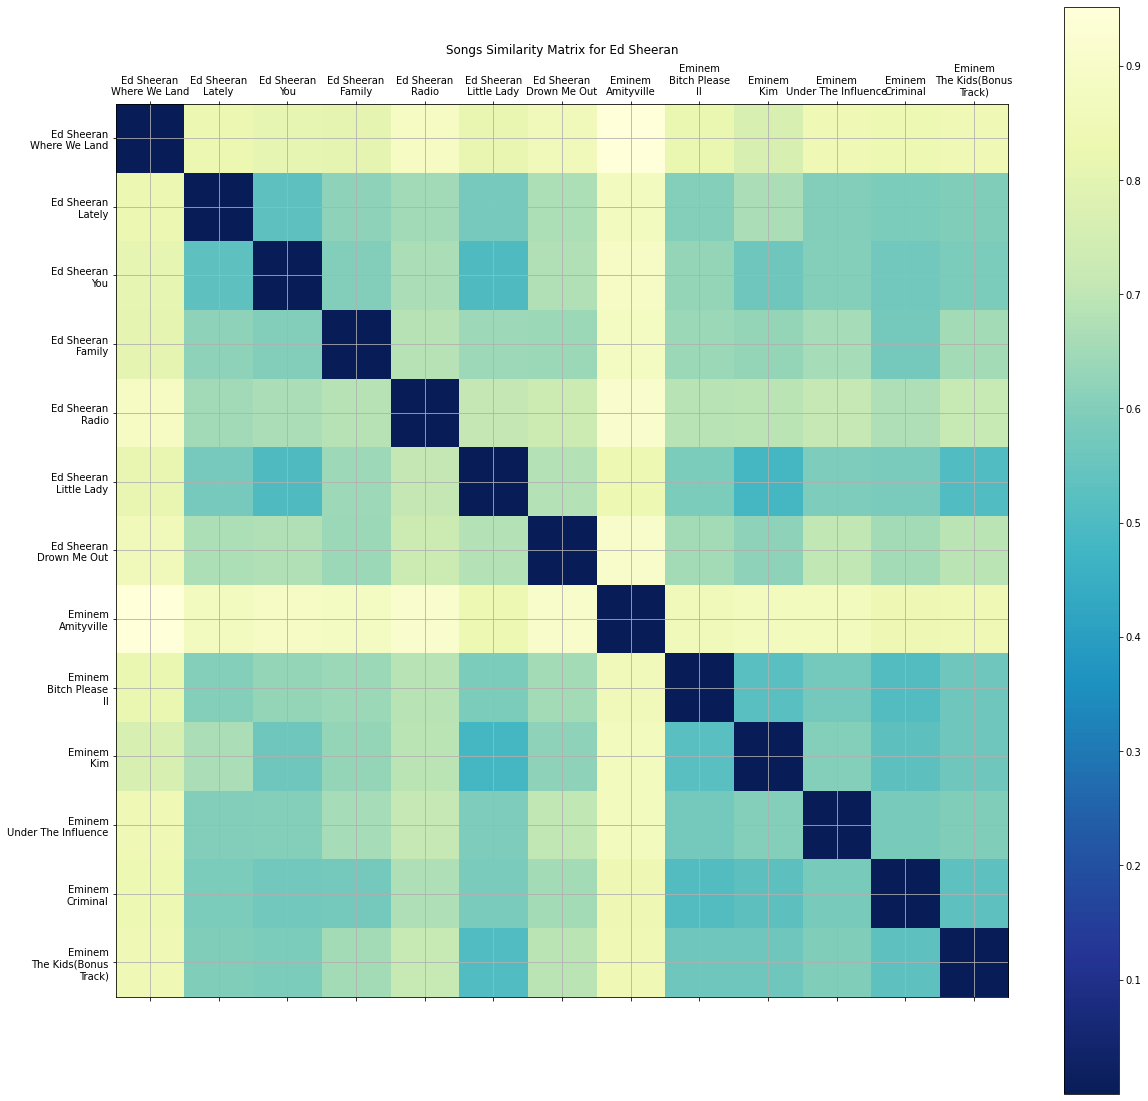

In [ ]:
compute_pairwise_similarities_for_diff_artist(dataset_csv, "Ed Sheeran", [46, 47, 48, 49, 50, 51, 52], "Eminem", [54, 55, 56, 57, 58, 59], 20)

In [ ]:
# Print all
# for selected_artist in list(Counter(dataset_csv['artist']).keys()):
#     compute_pairwise_similarities_for_artist(dataset_csv, selected_artist, fig_size=30)

# Word Clouds

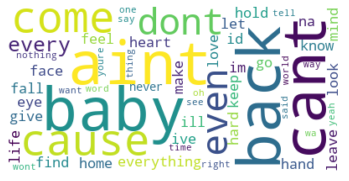

In [66]:
get_word_cloud_for_artist("Adele")

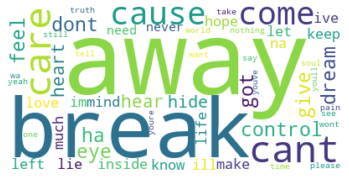

In [89]:
get_word_cloud_for_artist("Muse")